In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import re
import datetime
import h5py
import netCDF4
import os
from astropy.time import Time
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pickle
import shapely as shp
from scipy import interpolate
import xarray as xr
from typing import Tuple
import pyproj
from shapely.geometry import Point
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import cartopy.crs as ccrs
import cartopy

In [131]:
def transform_coords(x: float, y: float, in_epsg: str, out_epsg: str) -> Tuple[float, float]:
    """
    Transforms coordinates from one projection to another using pyproj.

    Args:
        x: The x-coordinate.
        y: The y-coordinate.
        in_epsg: The EPSG code of the input projection.
        out_epsg: The EPSG code of the output projection.

    Returns:
        A tuple of the transformed (x, y) coordinates.
    """
    source_crs = pyproj.CRS(in_epsg)
    destination_crs = pyproj.CRS(out_epsg)
    transformer = pyproj.Transformer.from_crs(source_crs, destination_crs, always_xy=True)
    return transformer.transform(x, y)

def cci_l2p_to_gdf(file, out_epsg):
    data = netCDF4.Dataset(file)
    latitude_field = "lat" if "lat" in data.variables else "latitude"
    longitude_field = "lon" if "lon" in data.variables else "longitude"
    d = {
        'latitude': np.array(data[latitude_field]),
        'longitude': np.array(data[longitude_field]),
        'sea_ice_freeboard': np.array(data["sea_ice_freeboard"]),
        'sea_ice_thickness': np.array(data["sea_ice_thickness"]),
        'sea_ice_thickness_unc': np.array(data["sea_ice_thickness_uncertainty"]),
        'snow_depth': np.array(data["snow_depth"]),
        'time': np.array(data["time"])
    }
    df = pd.DataFrame(data=d)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=4326)
    return gdf.to_crs(out_epsg)

In [207]:
buoy_file = '/Users/rricker/Downloads/MOSAiC_SIMBA_snow_depth_ice_thickness-3/datasets/2019T47_snow_depth_ice_thickness.tab'
out_epsg = 'EPSG:6931'

# Read the file while excluding lines between /* and */
with open(buoy_file, 'r') as file:
    lines = file.readlines()

# Identify the lines to skip between /* and */
skip_start = lines.index('/* DATA DESCRIPTION:\n')
skip_end = lines.index('*/\n') + 1
skip_lines = list(range(skip_start, skip_end))

# Read the data into a DataFrame excluding the lines between /* and */
data_df = pd.read_csv(buoy_file, sep='\t', skiprows=skip_lines, parse_dates=['Date/Time'])

# Create a GeoDataFrame from the DataFrame with a Point geometry
geometry = [Point(xy) for xy in zip(data_df['Longitude'], data_df['Latitude'])]
gdf = gpd.GeoDataFrame(data_df, geometry=geometry, crs = 'epsg:4326')
gdf = gdf.to_crs(out_epsg)

# Rename columns
column_mapping = {
    'Date/Time': 'time',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'Ice thick [m]': 'sea_ice_thickness',
    'Snow thick [m]': 'snow_depth'
}

gdf = gdf.rename(columns=column_mapping)
gdf['time'] = gdf['time'].dt.to_pydatetime()


In [184]:
file = '/Volumes/data2/projects/DriftAware-SIAlt/product/cryosat2/geojson/sea_ice_thickness-nh-16fr-epsg6931_111-2023-11-21_10-02-27/sea_ice_thickness-cryosat2-nh-20191130-v100-epsg6931_141.geojson'
data = gpd.read_file(file)

In [187]:
data_filt = data[np.abs(data['dt_days'])==15]
target_location = data_filt["geometry"].apply(lambda g: g.geoms[-1])

In [185]:
cday = datetime.datetime.strptime(
    re.split('-', os.path.basename(file))[3], '%Y%m%d') + datetime.timedelta(hours=12)
idx = np.argmin(np.abs(gdf['time']-cday))
buoy_x, buoy_y = transform_coords(gdf.loc[idx].longitude, gdf.loc[idx].latitude, 'EPSG:4326','EPSG:6931')
buoy_point = Point(buoy_x, buoy_y)

In [203]:
closest_point

/Users/rricker/miniforge3/envs/is2snow-env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/rricker/miniforge3/envs/is2snow-env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/rricker/miniforge3/envs/is2snow-env/lib/python3.8/site-packages/pandas/io/formats/printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-pa

sea_ice_thickness                                                        1.306298
sea_ice_thickness_std                                                    0.563115
sea_ice_thickness_hist          1 1 3 9 9 8 5 4 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 ...
sea_ice_thickness_unc                                                    0.127859
snow_depth                                                                0.22783
t0                                                              1576414512.342442
dt_days                                                                        15
ice_conc                                                                 0.977328
sea_ice_thickness_drift_unc                                              0.429333
divergence                      0 0.208 0.149 0.171 -0.04 -0.089 -0.165 -0.118...
shear                           0 0.291 0.134 0.132 0.378 0.231 0.105 0.123 0....
sea_ice_thickness_corr                                                   1.050266
sea_ice_thicknes

In [200]:
dist = target_location.distance(buoy_point)
closest_point_index = dist.idxmin()
closest_point = data_filt.loc[closest_point_index]

/var/folders/sh/kwy4x62d2mv1cgnwsyd94gzr0000gn/T/ipykernel_16446/2126947457.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist = target_location.distance(buoy_point)


In [196]:
da_points = list(closest_point.geoms)
da_x_coords, da_y_coords = zip(*[(point.x, point.y) for point in da_points])

In [197]:
buoy_points = gdf.loc[idx:idx+15]['geometry']
buoy_x_coords, buoy_y_coords = zip(*[(point.x, point.y) for point in buoy_points])

(328633.1475840725, 460640.13948010403, 133248.42484343238, 217346.57014896025)

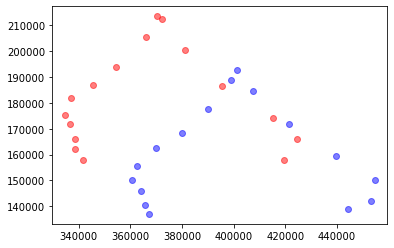

In [198]:
plt.scatter(da_x_coords, da_y_coords, color='blue', label='Individual Points', alpha=0.5)
plt.scatter(buoy_x_coords, buoy_y_coords, color='red', label='Individual Points', alpha=0.5)
plt.axis('equal')  # or plt.gca().set_aspect('equal')

In [189]:
closest_point

/Users/rricker/miniforge3/envs/is2snow-env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/rricker/miniforge3/envs/is2snow-env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/rricker/miniforge3/envs/is2snow-env/lib/python3.8/site-packages/pandas/io/formats/printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-pa

sea_ice_thickness                                                        1.306298
sea_ice_thickness_std                                                    0.563115
sea_ice_thickness_hist          1 1 3 9 9 8 5 4 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 ...
sea_ice_thickness_unc                                                    0.127859
snow_depth                                                                0.22783
t0                                                              1576414512.342442
dt_days                                                                        15
ice_conc                                                                 0.977328
sea_ice_thickness_drift_unc                                              0.429333
divergence                      0 0.208 0.149 0.171 -0.04 -0.089 -0.165 -0.118...
shear                           0 0.291 0.134 0.132 0.378 0.231 0.105 0.123 0....
sea_ice_thickness_corr                                                   1.050266
sea_ice_thicknes

In [102]:
def get_neighbor_dyn_range(row, data, var, tree):
    point = (row['geometry'].x, row['geometry'].y)
    neighbors_indices = tree.query_ball_point(point, row[var+'_drift_unc'], p=2.0)
    print(neighbors_indices)
    if not neighbors_indices:
        return 0.0  # Handle the case when there are no neighbors

    neighbor_thickness = data.loc[neighbors_indices, var].values
    return np.percentile(neighbor_thickness, 75) - np.percentile(neighbor_thickness, 25)


In [4]:
cday = datetime.datetime(2019, 11, 11, 0, 0, 0)
subs = cday.strftime("%Y%m%d")
file_f = '/Volumes/data2/projects/DriftAware-SIAlt/product/cryosat2/geojson/sea_ice_thickness-nh-16fr-epsg6931_111-2023-11-21_10-02-27/sea_ice_thickness-cryosat2-nh-20191111-v100-f-epsg6931_141.geojson'
file_r = '/Volumes/data2/projects/DriftAware-SIAlt/product/cryosat2/geojson/sea_ice_thickness-nh-16fr-epsg6931_111-2023-11-21_10-02-27/sea_ice_thickness-cryosat2-nh-20191111-v100-r-epsg6931_141.geojson'
stack_f = gpd.read_file(file_f)
stack_r = gpd.read_file(file_r)
stack_r = stack_r[stack_r.dt_days != 0].reset_index(drop=True)
data = pd.concat([stack_f, stack_r], ignore_index=True)
data.crs = 'EPSG:6931'
traj_geom = data['geometry']
target_location = data["geometry"].apply(lambda g: g.geoms[-1])
data["geometry"] = target_location

In [206]:
0.011 * 15.0

0.16499999999999998

In [211]:
import requests
url="https://iabp.apl.uw.edu/WebData/LEVEL2/"
response = requests.get(url)

In [213]:
response.read()

AttributeError: 'Response' object has no attribute 'read'

In [215]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

base_url = "https://iabp.apl.uw.edu/WebData/LEVEL2"

# Make a request to the base URL
response = requests.get(base_url)

if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract the filenames from the href attributes of <a> tags
    filenames = [a['href'] for a in soup.find_all('a') if a.has_attr('href')]


In [237]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

base_url = "https://iabp.apl.uw.edu/WebData/LEVEL2/"
output_directory = "/Users/rricker/Data/buoys"  # Replace with your desired output directory

# Make a request to the base URL
response = requests.get(base_url)

if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract filenames ending with ".dat" from the href attributes of <a> tags
    filenames = [a['href'] for a in soup.find_all('a') if a.has_attr('href') and a['href'].endswith('.dat')]

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Download each file and save it to the output directory
    for filename in filenames:
        url = urljoin(base_url, filename)
        response_file = requests.get(url)

        if response_file.status_code == 200:
            output_path = os.path.join(output_directory, filename)
            print(output_path)
            with open(output_path, 'wb') as file:
                file.write(response_file.content)
            print(f"File '{filename}' downloaded and saved to '{output_path}' successfully.")
        else:
            print(f"Failed to download the file '{filename}'. Status code: {response_file.status_code}")

else:
    print(f"Failed to retrieve the base URL. Status code: {response.status_code}")


/Users/rricker/Data/buoys/38.L2.dat
File '38.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/38.L2.dat' successfully.
/Users/rricker/Data/buoys/41080.L2.dat
File '41080.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/41080.L2.dat' successfully.
/Users/rricker/Data/buoys/41081.L2.dat
File '41081.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/41081.L2.dat' successfully.
/Users/rricker/Data/buoys/101630.L2.dat
File '101630.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/101630.L2.dat' successfully.
/Users/rricker/Data/buoys/127317.L2.dat
File '127317.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/127317.L2.dat' successfully.
/Users/rricker/Data/buoys/128652.L2.dat
File '128652.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/128652.L2.dat' successfully.
/Users/rricker/Data/buoys/132465.L2.dat
File '132465.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/132465.L2.dat' successfully.
/Users/rricker/Data/buoys/13247

/Users/rricker/Data/buoys/300234011932580.L2.dat
File '300234011932580.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234011932580.L2.dat' successfully.
/Users/rricker/Data/buoys/300234060108820.L2.dat
File '300234060108820.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234060108820.L2.dat' successfully.
/Users/rricker/Data/buoys/300234060430010.L2.dat
File '300234060430010.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234060430010.L2.dat' successfully.
/Users/rricker/Data/buoys/300234060434550.L2.dat
File '300234060434550.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234060434550.L2.dat' successfully.
/Users/rricker/Data/buoys/300234060436000.L2.dat
File '300234060436000.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234060436000.L2.dat' successfully.
/Users/rricker/Data/buoys/300234060654200.L2.dat
File '300234060654200.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234060654200.L2.dat' succes

/Users/rricker/Data/buoys/300234062423070.L2.dat
File '300234062423070.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062423070.L2.dat' successfully.
/Users/rricker/Data/buoys/300234062424060.L2.dat
File '300234062424060.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062424060.L2.dat' successfully.
/Users/rricker/Data/buoys/300234062426060.L2.dat
File '300234062426060.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062426060.L2.dat' successfully.
/Users/rricker/Data/buoys/300234062426150.L2.dat
File '300234062426150.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062426150.L2.dat' successfully.
/Users/rricker/Data/buoys/300234062428050.L2.dat
File '300234062428050.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062428050.L2.dat' successfully.
/Users/rricker/Data/buoys/300234062440570.L2.dat
File '300234062440570.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062440570.L2.dat' succes

/Users/rricker/Data/buoys/300234062956270.L2.dat
File '300234062956270.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062956270.L2.dat' successfully.
/Users/rricker/Data/buoys/300234062957280.L2.dat
File '300234062957280.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062957280.L2.dat' successfully.
/Users/rricker/Data/buoys/300234062958280.L2.dat
File '300234062958280.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234062958280.L2.dat' successfully.
/Users/rricker/Data/buoys/300234063061350.L2.dat
File '300234063061350.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063061350.L2.dat' successfully.
/Users/rricker/Data/buoys/300234063121390.L2.dat
File '300234063121390.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063121390.L2.dat' successfully.
/Users/rricker/Data/buoys/300234063163590.L2.dat
File '300234063163590.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063163590.L2.dat' succes

/Users/rricker/Data/buoys/300234063806040.L2.dat
File '300234063806040.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063806040.L2.dat' successfully.
/Users/rricker/Data/buoys/300234063843340.L2.dat
File '300234063843340.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063843340.L2.dat' successfully.
/Users/rricker/Data/buoys/300234063843680.L2.dat
File '300234063843680.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063843680.L2.dat' successfully.
/Users/rricker/Data/buoys/300234063844680.L2.dat
File '300234063844680.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063844680.L2.dat' successfully.
/Users/rricker/Data/buoys/300234063861170.L2.dat
File '300234063861170.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063861170.L2.dat' successfully.
/Users/rricker/Data/buoys/300234063869150.L2.dat
File '300234063869150.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234063869150.L2.dat' succes

/Users/rricker/Data/buoys/300234065497180.L2.dat
File '300234065497180.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234065497180.L2.dat' successfully.
/Users/rricker/Data/buoys/300234065499180.L2.dat
File '300234065499180.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234065499180.L2.dat' successfully.
/Users/rricker/Data/buoys/300234065511590.L2.dat
File '300234065511590.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234065511590.L2.dat' successfully.
/Users/rricker/Data/buoys/300234065511790.L2.dat
File '300234065511790.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234065511790.L2.dat' successfully.
/Users/rricker/Data/buoys/300234065511810.L2.dat
File '300234065511810.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234065511810.L2.dat' successfully.
/Users/rricker/Data/buoys/300234065511820.L2.dat
File '300234065511820.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234065511820.L2.dat' succes

/Users/rricker/Data/buoys/300234066035120.L2.dat
File '300234066035120.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234066035120.L2.dat' successfully.
/Users/rricker/Data/buoys/300234066038230.L2.dat
File '300234066038230.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234066038230.L2.dat' successfully.
/Users/rricker/Data/buoys/300234066039120.L2.dat
File '300234066039120.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234066039120.L2.dat' successfully.
/Users/rricker/Data/buoys/300234066042510.L2.dat
File '300234066042510.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234066042510.L2.dat' successfully.
/Users/rricker/Data/buoys/300234066049500.L2.dat
File '300234066049500.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234066049500.L2.dat' successfully.
/Users/rricker/Data/buoys/300234066300060.L2.dat
File '300234066300060.L2.dat' downloaded and saved to '/Users/rricker/Data/buoys/300234066300060.L2.dat' succes

In [233]:
base_url = "https://iabp.apl.uw.edu/WebData/LEVEL2/"
output_directory = "/Users/rricker/Data/buoys"  # Replace with your desired output directory

# Make a request to the base URL
response = requests.get(base_url)

if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract filenames ending with ".dat" from the href attributes of <a> tags
    filenames = [a['href'] for a in soup.find_all('a') if a.has_attr('href') and a['href'].endswith('.dat')]

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)



In [234]:
url = urljoin(base_url, filenames[0])

In [235]:
response_file = requests.get(url)

In [261]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Specify the directory containing the ".dat" files
dat_directory = "/Users/rricker/Data/buoys"  # Replace with the path to your directory

gdf = gpd.GeoDataFrame(columns=['BuoyID', 'Year', 'Hour', 'Min', 'DOY', 'POS_DOY', 'Lat', 'Lon'], geometry=[])

for filename in os.listdir(dat_directory):
    if filename.endswith(".dat"):
        filepath = os.path.join(dat_directory, filename)

        # Read the first line of the .dat file to get column names
        with open(filepath, 'r') as file:
            first_line = file.readline().strip()

        # Derive column names from the first line
        column_names = first_line.split()

        # Read the .dat file into a DataFrame, skipping the first two lines
        df = pd.read_csv(filepath, sep='\s+', skiprows=2, names=column_names)

        # Create a GeoDataFrame from the DataFrame
        geometry = [Point(lon, lat) for lon, lat in zip(df['Lon'], df['Lat'])]
        gdf_temp = gpd.GeoDataFrame(df, geometry=geometry)

        # Append to the main GeoDataFrame
        gdf = gdf.append(gdf_temp, ignore_index=True)
        
        gdf_final = gdf_final[(gdf_final['Lon']<=180) & (gdf_final['Lon']>=-180)].reset_index(drop=True)
        gdf_final = gdf_final[(gdf['Lat']<=90) & (gdf_final['Lat']>=45)].reset_index(drop=True)
        gdf_final.crs = 'epsg:4326'
        gdf_final = gdf_final.to_crs('epsg:6931')
        gdf_final.drop(columns=['Ts', 'BP', 'Ta'], inplace=True)
        

In [333]:
gdf_final.drop(columns=['Ts', 'BP', 'Ta'], inplace=True)

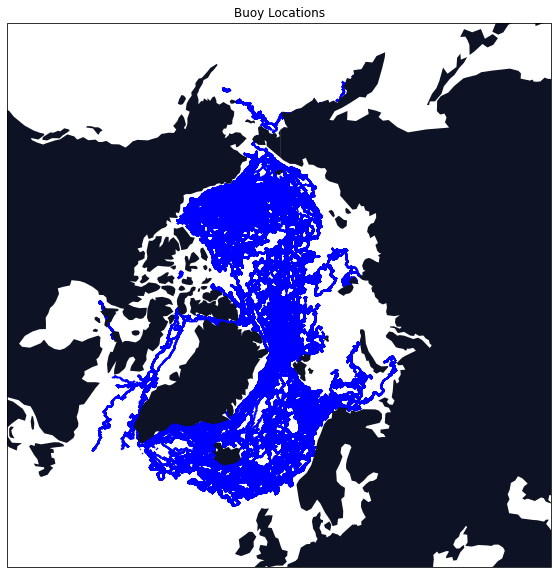

In [324]:
# Plot the GeoDataFrame on a map
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0, false_easting=0.0,
                                     false_northing=0.0)
gdf_final = gdf_final.to_crs('epsg:6931')
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': projection})
ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())  # Adjust extent based on your data
gdf_final.plot(ax=ax, marker='.', color='blue', markersize=1)
ax.add_feature(cartopy.feature.LAND, facecolor=[(0.05, 0.07, 0.14)], zorder=2)
ax.set_title('Buoy Locations')
plt.show()

In [317]:
from datetime import datetime, timedelta

def decimal_day_to_datetime(year, decimal_day):
    # Calculate the day and fractional seconds
    day = int(decimal_day)
    seconds_in_day = int((decimal_day - day) * 86400)

    # Create a datetime object for the given year, month, and day
    base_date = datetime(year, 1, 1)
    target_date = base_date + timedelta(days=day - 1, seconds=seconds_in_day)

    return target_date

# Example usage:
year = 2017
decimal_day = 70.930  # Example decimal day

result_datetime = decimal_day_to_datetime(year, decimal_day)
print(result_datetime)


2017-03-11 22:19:12


In [28]:
file = "/Users/rricker/GitLab/projects/DriftAware-SIAlt/merged.pickle"
merged = pd.read_pickle(file)

In [64]:
tmp = (merged.groupby(['index_right', 'dt_days'], as_index=False)
       .agg({'geometry': 'first', 'sea_ice_thickness': 'mean'})
       .pipe(gpd.GeoDataFrame, geometry='geometry', crs=merged.crs))

n_tiepoints = tmp.groupby('index_right')['dt_days'].count()
valid_indices = n_tiepoints[n_tiepoints >= 3].index
tmp = tmp[tmp['index_right'].isin(valid_indices)]
tmp.set_index('index_right', inplace=True)

eps = 1.8
fsm = interpolate.interp1d(np.array([40.0, 90.0]), np.array([80, 10]))

# perform linear fit
tmp['coeff'] = tmp.groupby('index_right').apply(
    lambda x: np.polyfit(x['dt_days'], x["sea_ice_thickness"], deg=1, cov=True))
tmp['growth'] = [x[0][0] for x in tmp['coeff'].values]
tmp['growth_unc'] = [np.sqrt(np.diag(x[1])[1]) for x in tmp['coeff'].values]
tmp[(tmp['growth'] > 2.5) | (tmp['growth'] < -2.5)] = np.nan

In [65]:
tg = pd.merge(merged, tmp[~tmp.index.duplicated(keep='first')].reset_index(), left_on='index_right', right_on='index_right', how='left')

In [66]:
tg['growth'].count()

2720

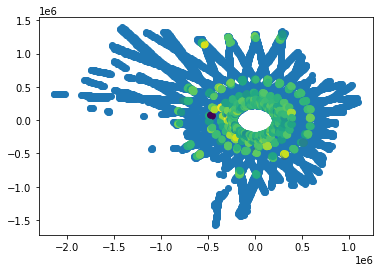

In [67]:
plt.scatter(tg['geometry_x'].x,tg['geometry_x'].y)
plt.scatter(tg['geometry_x'].x,tg['geometry_x'].y, c=tg['growth'], cmap='viridis')